In [1]:
import random
from itertools import combinations

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.special import comb

from hypergraphs_arsham import *

In [2]:
def random_hypergraph(N, ps):
    """Generates a random hypergraph

    Generate N nodes, and connect any d+1 nodes
    by a hyperedge with probability ps[d].

    Parameters
    ----------
    N : int
        Number of nodes
    ps : list of floats
        Probabilities (between 0 and 1) to create a hyperedge
        at each order d between any d+1 nodes. ps[0] is edges,
        ps[1] for triangles, etc.

    Returns
    -------
    List of tuples
        List of hypergraphs
    """

    # I first generate a standard ER graph with edges connected with probability p1
    G = nx.fast_gnp_random_graph(N, ps[0], seed=None)

    nodes = G.nodes()
    hyperedges = list(G.edges())

    for i, p in enumerate(ps[1:]):
        d = i + 2  # order (+2 because we started with [1:])
        for hyperedge in combinations(nodes, d + 1):
            if random.random() <= p:
                hyperedges.append(hyperedge)

    return sort_hyperedges(hyperedges)

In [121]:
def random_nested_generator(N, d_max, p_max, p_lower, p_swap):
    """Generates a random hypergraph with maximum order d_max.

    The hypergraph is generated as follows:
        1. Create a d_max-hyperedge with probabilty p_max
           for any d_max+1 nodes.
        2. Go down one order to d=d_max-1
            a. For each d+1 hyperedge, create a d-hyperedge
            for any of its d+1 nodes with probability p_lower
            b. For each of those d-hyperedges created,
            replace each node by an outside node with
            probability p_swap.
            c. Start again at 2. until reaching d=1.
    p_swap controls how nested or random the hypergraph is.

    Parameters
    ----------
    N : int
        Number of nodes
    d_max : int
        Maximum order of hyperedge in the hypergraph
    p_max : float
        Probability to create a d_max-hyperedge
        from any d_max+1 nodes
    p_lower : float
        Probability to create a (d-1)-hyperedge
        for any face of an existing d-hyperedge
    p_swap : float
        Probability of each node in a hyperedge
        to be replaced by a node not in that hyperedge
        If p_swap=0, then the hypergraph is fully nested
        by construction: each hyperedge is the face of a hyperedge
        of the order above. If p_swap=1, then the hypergraph
        should be fully random.
    """

    if p_max < 0 or p_max > 1:
        raise ValueError("p_max should be between 0 and 1")
    if p_lower < 0 or p_lower > 1:
        raise ValueError("p_max should be between 0 and 1")
    if p_swap < 0 or p_swap > 1:
        raise ValueError("p_max should be between 0 and 1")

    nodes = range(N)

    hyperedges = []
    hyperedges_d = []

    # add hyperedges of order d_max with prob p_max
    for hyperedge in combinations(nodes, d_max + 1):
        if random.random() <= p_max:
            hyperedges_d.append(hyperedge)

    hyperedges.append(hyperedges_d)

    # now go down in the orders
    ds = range(d_max - 1, 0, -1)
    for i, d in enumerate(ds):

        hyperedges_up = hyperedges[i]
        hyperedges_d = []

        for hyperedge_up in hyperedges_up:

            # add each face of order d-1 with prob p_lower
            for hyperedge in combinations(hyperedge_up, d + 1):

                if random.random() <= p_lower:  # add d-1 face
                    # replace each node in hyperedge
                    # by a node outside of it with prob p_swap
                    valid_add = False

                    if len(hyperedges_d) == comb(N, d + 1):
                        raise ValueError(
                            f"All {d}-hyperedges already exist. Not possible to add more."
                        )

                    while not valid_add:
                        hyperedge_swapped = []
                        nodes_outside = list(set(nodes).difference(hyperedge))
                        # modify hyperedge by replacing nodes
                        for node in hyperedge:
                            if random.random() <= p_swap:  # replace
                                node_new = random.choice(nodes_outside)
                                nodes_outside.remove(node_new)  # avoid twice same node
                            else:
                                node_new = node
                            hyperedge_swapped.append(node_new)
                        hyperedge_swapped = tuple(sorted(hyperedge_swapped))
                        #                         print(hyperedge, '-->', hyperedge_swapped)
                        # check that modified hyperedge is valid, i.e.
                        # it does not exist yet. If it does, start over.
                        if hyperedge_swapped not in hyperedges_d:
                            valid_add = True
                            hyperedges_d.append(tuple(hyperedge_swapped))
                        else:
                            continue
                #                             print('existing hyperedge, start over')
                #                             print('-----------------', hyperedge, hyperedge_swapped)
                #                             print(hyperedges_d)

                else:  # do not add face
                    continue

        hyperedges.append(hyperedges_d)

        hyperedges_flat = [he for sublist in hyperedges for he in sublist]
        hyperedges_flat = sort_hyperedges(hyperedges_flat)

        # make sure there are no duplicates
        uni, counts = np.unique(hyperedges_flat, return_counts=True)
        assert len(uni[counts > 1]) == 0

    return hyperedges_flat

In [215]:
def random_nested_generator(N, d_max, p_max, n_lower, p_swap):
    """Generates a random hypergraph with maximum order d_max.

    The hypergraph is generated as follows:
        1. Create a d_max-hyperedge with probabilty p_max
           for any d_max+1 nodes.
        2. Go down one order to d=d_max-1
            a. For each d+1 hyperedge, create a d-hyperedge
            for any of its d+1 nodes with probability p_lower
            b. For each of those d-hyperedges created,
            replace each node by an outside node with
            probability p_swap.
            c. Start again at 2. until reaching d=1.
    p_swap controls how nested or random the hypergraph is.

    Parameters
    ----------
    N : int
        Number of nodes
    d_max : int
        Maximum order of hyperedge in the hypergraph
    p_max : float
        Probability to create a d_max-hyperedge
        from any d_max+1 nodes
    n_lower : float
        Average number of face [(d-1)-hyperedge]
        per existing d-hyperedge. For any of the d subfaces,
        the probability to create a hyperedge
        is p_lower = n_lower / d
    p_swap : float
        Probability of each node in a hyperedge
        to be replaced by a node not in that hyperedge
        If p_swap=0, then the hypergraph is fully nested
        by construction: each hyperedge is the face of a hyperedge
        of the order above. If p_swap=1, then the hypergraph
        should be fully random.

    Returns
    -------
    hyperedges : list of list of tuples
        Each element is a list hyperedges at a given order
    hyperedges_flat : list of tuples
        List of hyperedges sorted by size (flattened version of 'hyperedges')
    """

    if p_max < 0 or p_max > 1:
        raise ValueError("p_max should be between 0 and 1")
    if n_lower < 0 or n_lower > d_max:
        raise ValueError(
            "n_lower between 0 and d_max so that p_lower is between 0 and 1."
        )
    if p_swap < 0 or p_swap > 1:
        raise ValueError("p_swap should be between 0 and 1")

    nodes = range(N)

    hyperedges = []
    hyperedges_d = []

    # add hyperedges of order d_max with prob p_max
    for hyperedge in combinations(nodes, d_max + 1):
        if random.random() <= p_max:
            hyperedges_d.append(hyperedge)

    hyperedges.append(hyperedges_d)

    # now go down in the orders
    ds = range(d_max - 1, 0, -1)
    for i, d in enumerate(ds):

        hyperedges_up = hyperedges[i]
        hyperedges_d = []

        for hyperedge_up in hyperedges_up:

            # add each face of order d-1 with prob p_lower
            for hyperedge in combinations(hyperedge_up, d + 1):

                p_lower = n_lower / (d + 2)
                if p_lower > 1:
                    raise ValueError("p_lower cannot be >1")

                if random.random() <= p_lower:  # add d-1 face
                    # replace each node in hyperedge
                    # by a node outside of it with prob p_swap
                    valid_add = False

                    if len(hyperedges_d) == comb(N, d + 1):
                        raise ValueError(
                            f"All {d}-hyperedges already exist. Not possible to add more."
                        )

                    while not valid_add:
                        hyperedge_swapped = []
                        nodes_outside = list(set(nodes).difference(hyperedge))
                        # modify hyperedge by replacing nodes
                        for node in hyperedge:
                            if random.random() <= p_swap:  # replace
                                node_new = random.choice(nodes_outside)
                                nodes_outside.remove(node_new)  # avoid twice same node
                            else:
                                node_new = node
                            hyperedge_swapped.append(node_new)
                        hyperedge_swapped = tuple(sorted(hyperedge_swapped))
                        #                         print(hyperedge, '-->', hyperedge_swapped)
                        # check that modified hyperedge is valid, i.e.
                        # it does not exist yet. If it does, start over.
                        if hyperedge_swapped not in hyperedges_d:
                            valid_add = True
                            hyperedges_d.append(tuple(hyperedge_swapped))
                        else:
                            pass
                            if p_swap == 0:  # no chance to change, infinite loop
                                print(
                                    f"Hyperedge {hyperedge_swapped} already exists",
                                    f"not added because p_swap=0",
                                )
                                break
                #                             print('existing hyperedge, start over')
                #                             print('-----------------', hyperedge, hyperedge_swapped)
                #                             print(hyperedges_d)

                else:  # do not add face
                    continue

        hyperedges.append(hyperedges_d)

        hyperedges_flat = [he for sublist in hyperedges for he in sublist]
        hyperedges_flat = sort_hyperedges(hyperedges_flat)

        # make sure there are no duplicates
        uni, counts = np.unique(hyperedges_flat, return_counts=True)
        assert len(uni[counts > 1]) == 0

    return hyperedges_flat, hyperedges

In [221]:
hyperedges_flat, hyperedges = random_nested_generator(
    N=100, d_max=3, p_max=0.001, n_lower=1, p_swap=0
)

Hyperedge (0, 1, 18) already exists not added because p_swap=0
Hyperedge (0, 10, 19) already exists not added because p_swap=0
Hyperedge (1, 3, 49) already exists not added because p_swap=0
Hyperedge (2, 24, 91) already exists not added because p_swap=0
Hyperedge (3, 19, 84) already exists not added because p_swap=0
Hyperedge (5, 9, 67) already exists not added because p_swap=0
Hyperedge (5, 12, 20) already exists not added because p_swap=0
Hyperedge (5, 17, 75) already exists not added because p_swap=0
Hyperedge (5, 27, 77) already exists not added because p_swap=0
Hyperedge (6, 21, 67) already exists not added because p_swap=0
Hyperedge (7, 18, 22) already exists not added because p_swap=0
Hyperedge (28, 77, 93) already exists not added because p_swap=0
Hyperedge (7, 31, 38) already exists not added because p_swap=0
Hyperedge (7, 50, 51) already exists not added because p_swap=0
Hyperedge (10, 27, 83) already exists not added because p_swap=0
Hyperedge (10, 36, 54) already exists not

Hyperedge (14, 92) already exists not added because p_swap=0
Hyperedge (80, 92) already exists not added because p_swap=0
Hyperedge (15, 16) already exists not added because p_swap=0
Hyperedge (15, 76) already exists not added because p_swap=0
Hyperedge (15, 18) already exists not added because p_swap=0
Hyperedge (15, 97) already exists not added because p_swap=0
Hyperedge (47, 94) already exists not added because p_swap=0
Hyperedge (15, 24) already exists not added because p_swap=0
Hyperedge (15, 76) already exists not added because p_swap=0
Hyperedge (15, 80) already exists not added because p_swap=0
Hyperedge (76, 80) already exists not added because p_swap=0
Hyperedge (15, 29) already exists not added because p_swap=0
Hyperedge (15, 29) already exists not added because p_swap=0
Hyperedge (15, 78) already exists not added because p_swap=0
Hyperedge (29, 41) already exists not added because p_swap=0
Hyperedge (15, 35) already exists not added because p_swap=0
Hyperedge (33, 45) alrea

Hyperedge (25, 96) already exists not added because p_swap=0
Hyperedge (25, 41) already exists not added because p_swap=0
Hyperedge (25, 48) already exists not added because p_swap=0
Hyperedge (25, 43) already exists not added because p_swap=0
Hyperedge (25, 48) already exists not added because p_swap=0
Hyperedge (48, 64) already exists not added because p_swap=0
Hyperedge (42, 98) already exists not added because p_swap=0
Hyperedge (25, 45) already exists not added because p_swap=0
Hyperedge (73, 91) already exists not added because p_swap=0
Hyperedge (51, 58) already exists not added because p_swap=0
Hyperedge (25, 51) already exists not added because p_swap=0
Hyperedge (25, 70) already exists not added because p_swap=0
Hyperedge (25, 63) already exists not added because p_swap=0
Hyperedge (26, 52) already exists not added because p_swap=0
Hyperedge (30, 76) already exists not added because p_swap=0
Hyperedge (26, 31) already exists not added because p_swap=0
Hyperedge (26, 81) alrea

Hyperedge (68, 95) already exists not added because p_swap=0
Hyperedge (69, 78) already exists not added because p_swap=0
Hyperedge (76, 82) already exists not added because p_swap=0
Hyperedge (69, 78) already exists not added because p_swap=0
Hyperedge (69, 86) already exists not added because p_swap=0
Hyperedge (70, 90) already exists not added because p_swap=0
Hyperedge (76, 84) already exists not added because p_swap=0
Hyperedge (72, 93) already exists not added because p_swap=0
Hyperedge (82, 83) already exists not added because p_swap=0
Hyperedge (74, 93) already exists not added because p_swap=0
Hyperedge (75, 86) already exists not added because p_swap=0
Hyperedge (78, 81) already exists not added because p_swap=0


In [222]:
[len(i) for i in hyperedges]

[3969, 3873, 2655]

In [180]:
len(hyperedges_flat)

6876

In [113]:
uni, counts = np.unique(hyperedges_flat, return_counts=True)

/home/maxime/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [114]:
uni

array([(0, 3), (0, 3, 19, 20), (0, 3, 23), (0, 3, 23, 33), (0, 4, 15, 48),
       (0, 4, 32), (0, 5, 45, 48), (0, 7, 9, 32), (0, 7, 25, 27),
       (0, 7, 39, 48), (0, 10, 27, 36), (0, 11, 14, 45), (0, 11, 24, 30),
       (0, 11, 30), (0, 12), (0, 12, 25, 28), (0, 12, 28),
       (0, 13, 17, 38), (0, 13, 37, 43), (0, 13, 43), (0, 14, 23, 38),
       (0, 14, 29), (0, 14, 29, 44), (0, 14, 35, 45), (0, 15, 48),
       (0, 17), (0, 17, 38), (0, 17, 38, 42), (0, 17, 42), (0, 18, 22),
       (0, 18, 22, 44), (0, 18, 44), (0, 19), (0, 21), (0, 22, 25, 27),
       (0, 22, 27), (0, 25, 27), (0, 28), (0, 28, 35), (0, 28, 35, 43),
       (0, 28, 43), (0, 35, 43), (0, 35, 45), (0, 36), (0, 38, 39),
       (0, 38, 39, 43), (0, 39), (0, 39, 46), (0, 43), (0, 45),
       (0, 45, 48), (1, 3, 11, 33), (1, 3, 33), (1, 4, 20, 38),
       (1, 4, 36), (1, 4, 38), (1, 5, 15, 24), (1, 6), (1, 6, 41),
       (1, 6, 43), (1, 6, 43, 48), (1, 6, 48), (1, 7, 17, 18),
       (1, 7, 25, 48), (1, 9, 10), (1, 9, 45, 

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0., 589.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.]),
 array([0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64, 0.66, 0.68, 0.7 ,
        0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86, 0.88, 0.9 , 0.92,
        0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06, 1.08, 1.1 , 1.12, 1.14,
        1.16, 1.18, 1.2 , 1.22, 1.24, 1.26, 1.28, 1.3 , 1.32, 1.34, 1.36,
        1.38, 1.4 , 1.42, 1.44, 1.46, 1.48, 1.5 ]),
 <a list of 50 Patch objects>)

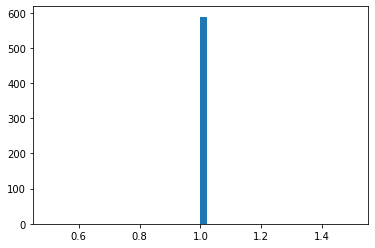

In [115]:
plt.hist(counts, bins=50)

In [120]:
len(uni[counts > 1]) == 0

True

In [96]:
hyperedges_flat

[(0, 5),
 (0, 16),
 (1, 2),
 (1, 6),
 (1, 11),
 (1, 13),
 (1, 20),
 (1, 21),
 (1, 25),
 (1, 29),
 (1, 30),
 (1, 33),
 (1, 49),
 (2, 15),
 (2, 33),
 (2, 34),
 (2, 38),
 (2, 45),
 (2, 49),
 (3, 4),
 (3, 15),
 (3, 16),
 (3, 18),
 (3, 36),
 (3, 38),
 (3, 42),
 (3, 45),
 (3, 46),
 (4, 8),
 (4, 22),
 (4, 33),
 (4, 39),
 (5, 7),
 (5, 23),
 (5, 28),
 (5, 49),
 (6, 9),
 (6, 14),
 (6, 18),
 (6, 21),
 (6, 23),
 (6, 28),
 (6, 34),
 (6, 37),
 (6, 38),
 (6, 41),
 (6, 43),
 (6, 47),
 (7, 14),
 (7, 23),
 (7, 25),
 (7, 29),
 (7, 33),
 (8, 11),
 (8, 21),
 (8, 25),
 (8, 26),
 (8, 28),
 (8, 49),
 (9, 11),
 (9, 15),
 (9, 23),
 (9, 24),
 (9, 33),
 (9, 37),
 (9, 47),
 (10, 11),
 (10, 15),
 (10, 20),
 (10, 27),
 (10, 30),
 (10, 34),
 (10, 40),
 (10, 41),
 (10, 42),
 (10, 44),
 (10, 45),
 (11, 29),
 (11, 37),
 (11, 40),
 (11, 46),
 (12, 19),
 (12, 33),
 (12, 35),
 (12, 42),
 (12, 46),
 (13, 14),
 (13, 15),
 (13, 16),
 (13, 35),
 (13, 37),
 (13, 41),
 (14, 16),
 (14, 20),
 (14, 26),
 (14, 27),
 (14, 38),
 (14, 

In [88]:
hyperedges

[[(0, 3, 27, 39),
  (0, 3, 31, 42),
  (0, 4, 32, 45),
  (0, 5, 26, 30),
  (0, 6, 13, 44),
  (0, 6, 15, 22),
  (0, 9, 12, 48),
  (0, 10, 37, 46),
  (0, 11, 19, 40),
  (0, 12, 28, 34),
  (0, 13, 23, 48),
  (0, 13, 35, 38),
  (0, 18, 20, 44),
  (0, 18, 28, 42),
  (0, 20, 26, 45),
  (0, 26, 30, 40),
  (0, 36, 44, 47),
  (1, 2, 13, 38),
  (1, 2, 32, 42),
  (1, 3, 8, 29),
  (1, 4, 18, 21),
  (1, 4, 32, 38),
  (1, 8, 11, 34),
  (1, 8, 28, 36),
  (1, 8, 39, 45),
  (1, 8, 45, 46),
  (1, 9, 22, 35),
  (1, 13, 15, 47),
  (1, 13, 39, 45),
  (1, 16, 19, 38),
  (1, 18, 19, 30),
  (1, 22, 35, 41),
  (1, 23, 37, 46),
  (1, 27, 34, 49),
  (2, 3, 9, 18),
  (2, 4, 10, 12),
  (2, 5, 9, 24),
  (2, 5, 11, 13),
  (2, 5, 12, 38),
  (2, 5, 14, 48),
  (2, 5, 20, 40),
  (2, 5, 23, 28),
  (2, 6, 12, 14),
  (2, 8, 12, 19),
  (2, 10, 18, 45),
  (2, 11, 27, 32),
  (2, 15, 26, 33),
  (2, 17, 18, 45),
  (2, 18, 23, 47),
  (2, 18, 25, 28),
  (2, 18, 33, 47),
  (2, 19, 21, 22),
  (2, 24, 37, 42),
  (2, 24, 48, 49),
  (3

In [45]:
N = 50
d_max = 4
p_max = 0.00001
p_lower = 1 / 4
p_swap = 0.5

nodes = range(N)

hyperedges = []
hyperedges_d = []

# add hyperedges of order d_max with prob p_max
for hyperedge in combinations(nodes, d_max + 1):
    if random.random() <= p_max:
        hyperedges_d.append(hyperedge)

hyperedges.append(hyperedges_d)

# now go down in the orders
ds = range(d_max - 1, 0, -1)
for i, d in enumerate(ds):

    print("===================================", i, d)

    hyperedges_up = hyperedges[i]
    hyperedges_d = []

    for hyperedge_up in hyperedges_up:

        print(hyperedge_up, "------")

        # add each face of order d-1 with prob p_lower
        for hyperedge in combinations(hyperedge_up, d + 1):

            if random.random() <= p_lower:
                # replace each node in hyperedge
                # by a node outside of it with prob p_swap
                nodes_outside = list(set(nodes).difference(hyperedge))
                hyperedge_swapped = []
                for node in hyperedge:
                    if random.random() <= p_swap:  # replace
                        node_new = random.choice(nodes_outside)
                    else:
                        node_new = node
                    hyperedge_swapped.append(node_new)

                print(hyperedge, hyperedge_swapped)
                hyperedges_d.append(hyperedge_swapped)
            else:
                continue  # do not add that face of order d-1

    hyperedges.append(hyperedges_d)

=================================== 0 3
(1, 5, 8, 20, 42) ------
(1, 8, 20, 42) [1, 41, 20, 42]
(5, 8, 20, 42) [5, 15, 20, 42]
(1, 6, 13, 30, 33) ------
(1, 6, 13, 30) [44, 6, 13, 30]
(1, 6, 13, 33) [1, 6, 41, 33]
(1, 6, 30, 33) [1, 6, 30, 33]
(1, 13, 30, 33) [1, 13, 0, 33]
(1, 9, 32, 46, 48) ------
(1, 32, 46, 48) [35, 23, 37, 48]
(1, 12, 31, 37, 41) ------
(1, 14, 17, 21, 29) ------
(1, 14, 17, 29) [9, 47, 17, 41]
(2, 4, 11, 30, 47) ------
(3, 11, 34, 39, 47) ------
(3, 34, 39, 47) [3, 34, 39, 12]
(4, 6, 14, 47, 48) ------
(4, 6, 14, 47) [38, 6, 14, 12]
(4, 6, 14, 48) [4, 19, 39, 40]
(4, 27, 34, 44, 48) ------
(5, 9, 24, 25, 45) ------
(6, 9, 14, 30, 41) ------
(6, 15, 25, 34, 40) ------
(6, 25, 34, 40) [6, 25, 34, 40]
(7, 8, 25, 35, 48) ------
(8, 25, 35, 48) [8, 25, 26, 48]
(7, 9, 20, 29, 33) ------
(7, 9, 20, 29) [7, 44, 20, 25]
(7, 20, 29, 33) [5, 20, 29, 22]
(7, 20, 33, 37, 42) ------
(7, 20, 33, 42) [7, 20, 45, 6]
(9, 11, 25, 26, 44) ------
(9, 11, 25, 44) [23, 47, 25, 8]
(9, 1

In [46]:
nodes_outside

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49]

In [42]:
nodes

range(0, 50)

In [38]:
hyperedges

[[(0, 10, 20, 22, 43),
  (0, 12, 13, 15, 32),
  (0, 22, 24, 32, 48),
  (1, 2, 21, 35, 39),
  (1, 13, 26, 31, 45),
  (3, 6, 16, 32, 40),
  (5, 12, 30, 35, 37),
  (5, 20, 22, 40, 48),
  (6, 10, 24, 29, 49),
  (7, 16, 20, 34, 39),
  (8, 19, 30, 34, 42),
  (9, 12, 14, 26, 35),
  (10, 14, 31, 32, 46),
  (10, 14, 37, 42, 49),
  (13, 18, 31, 33, 49),
  (15, 21, 25, 26, 31),
  (17, 37, 44, 45, 49)],
 [(0, 10, 22, 43),
  (0, 13, 15, 32),
  (0, 22, 24, 48),
  (2, 21, 35, 39),
  (1, 26, 31, 45),
  (3, 6, 16, 32),
  (3, 6, 16, 40),
  (5, 12, 30, 35),
  (5, 20, 22, 40),
  (5, 22, 40, 48),
  (16, 20, 34, 39),
  (8, 19, 30, 34),
  (9, 12, 26, 35),
  (12, 14, 26, 35),
  (10, 14, 42, 49),
  (10, 37, 42, 49),
  (13, 18, 31, 49),
  (13, 18, 33, 49),
  (15, 21, 25, 26),
  (15, 21, 25, 31),
  (17, 37, 44, 49),
  (17, 44, 45, 49)],
 [(10, 22, 43),
  (0, 13, 32),
  (0, 22, 24),
  (26, 31, 45),
  (3, 16, 32),
  (3, 16, 40),
  (12, 30, 35),
  (5, 20, 40),
  (5, 22, 40),
  (22, 40, 48),
  (20, 34, 39),
  (8, 19